In [1]:
# TODO: ~/src/anaconda3/envs/tf/lib/python3.6/site-packages/textgenrnn.bak/

#from textgenrnn import textgenrnn
from textgenrnn.textgenrnn import textgenrnn

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from textgenrnn.textgenrnn import utils

%matplotlib inline

def attention_map(prediction_text, x_lbls, weights):
    # https://github.com/datalogue/keras-attention/blob/master/visualize.py
    if '<pad>' in x_lbls:
        # replace "" after last "<pad>" with another "pad"
        last_pad = len(x_lbls) - 1 - x_lbls[::-1].index('<pad>')
        if last_pad + 1 < len(x_lbls):
            x_lbls[last_pad + 1] = '<pad>'
            
    #print(prediction_text, x_lbls)
    
    # get the activation map
    activation_map = [a[0] for a in weights]

    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

    # add labels
    ax.set_xticks(range(model_cfg['max_length']))
    ax.set_xticklabels([f'"{l}"' for l in x_lbls])

    ax.set_yticks(range(len(weights)))
    ax.set_yticklabels([f'"{t}"' for t in prediction_text])
    ax.yaxis.tick_right()

    ax.set_xlabel('History')
    ax.set_ylabel('Next word')

    #f.savefig(os.path.join(HERE, 'attention_maps', text.replace('/', '')+'.pdf'), bbox_inches='tight')
    return f, i
    
def sample(textgen, temperature=0.5, map_attention=True, max_len=20):
    # suppress runtime warning
    plt.rcParams.update({'figure.max_open_warning': max_len + 1})
    
    from keras.models import Model
    import re

    # https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    attn_model = Model(inputs=textgen.model.input, outputs=[textgen.model.get_layer('attention').output[1], textgen.model.output])
    
    next_word = ''
    text = [next_word]
    last_lbls = ['<pad>']*model_cfg['max_length']
    attn_weights = []

    if map_attention:
        plt.clf()
    while next_word != '<s>' and len(text) < max_len:
        encoded_text = utils.textgenrnn_encode_sequence(text, textgen.vocab, model_cfg['max_length'])

        preds = attn_model.predict(encoded_text)
        attn = preds[0]
        full_pred = preds[1]

        next_index = utils.textgenrnn_sample(full_pred[0], temperature)
        next_word = textgen.indices_char[next_index]

        text += [next_word]
        
        if map_attention:
            attn_lbl = list(['<pad>']*max(model_cfg['max_length']-len(text), 0) + text[-model_cfg['max_length']:])
            attention_map([next_word], last_lbls, [attn])
            attn_weights.append(attn)
            last_lbls = attn_lbl

    text_joined = ' '.join(text[1:])
    punct = '\\n\\t'
    print(re.sub(" ([{}]) ".format(punct), r'\1', text_joined))
    if map_attention:
        # add colorbar [left, bottom, width, height]
        f, i = attention_map(text, [], attn_weights)
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Weight', labelpad=4)
        plt.show()


from keras.callbacks import Callback

class sample_after_epoch(Callback):
    def __init__(self, textgen, sample_epochs, temperature=0.5, map_attention=True, max_len=20):
        self.textgen = textgen
        self.sample_epochs = sample_epochs
        self.temperature = temperature
        self.map_attention = map_attention
        self.max_len = max_len

    def on_epoch_end(self, epoch, logs={}):
        if self.sample_epochs > 0 and (epoch+1) % self.sample_epochs == 0:
            sample(self.textgen, temperature=self.temperature, map_attention=self.map_attention, max_len=self.max_len)

In [3]:
model_cfg = {
    'rnn_size': 128,
    'rnn_layers': 4,
    'rnn_bidirectional': True,
    'max_length': 10,#5,#300,
    'max_words': 100000,
    'dim_embeddings': 300,
    'word_level': True,
}

train_cfg = {
    'line_delimited': True,
    'num_epochs': 1,#10,
    'gen_epochs': 0,#1,#2,
    'sample_epochs': 1,
    'batch_size': 512,
    'train_size': 0.8,
    'dropout': 0.1,
    'max_gen_length': 300,
    'validation': True,
    'is_csv': False
}

37,768 texts collected.
Training new model w/ 4-layer, 128-cell Bidirectional LSTMs
Training on 5,210,040 word sequences.
Epoch 1/1
10175/10175 [==============================] - 642s 63ms/step - loss: 4.3619 - val_loss: 4.0978
- - : - - - - - - - - - - - - - - - -


<Figure size 432x288 with 0 Axes>

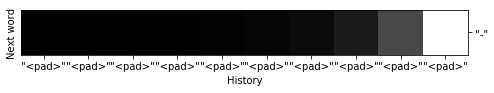

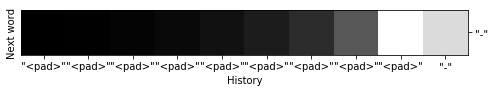

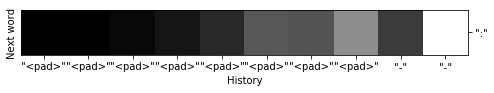

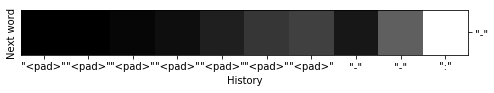

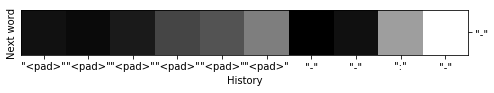

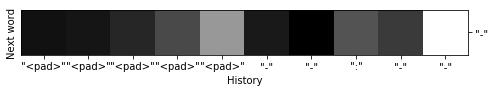

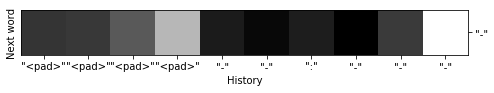

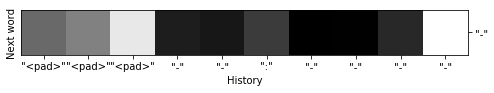

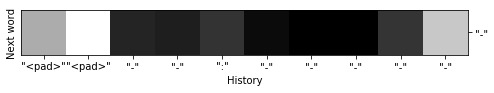

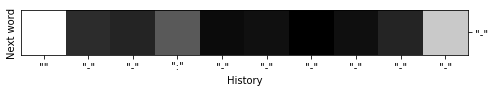

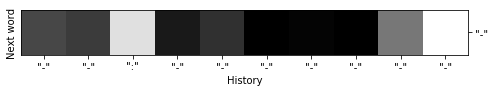

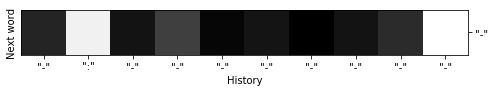

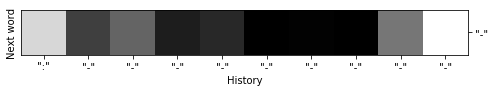

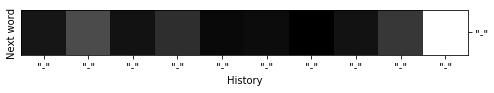

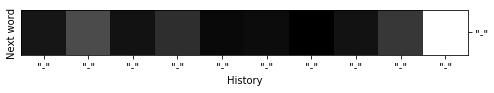

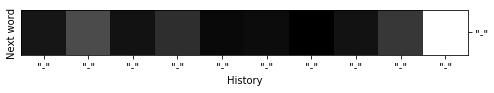

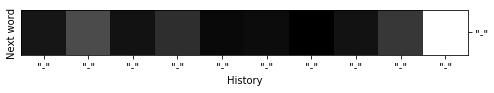

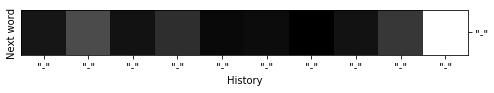

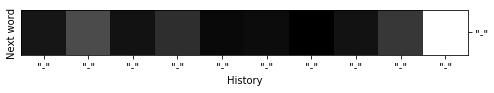

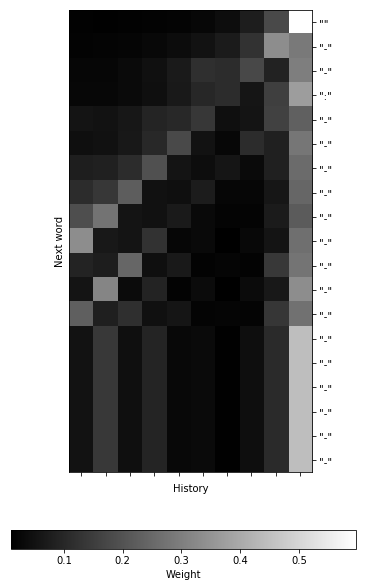

In [4]:
from pathlib import Path

data_path = Path('../datasets/')
model_name = 'reviews_lines'
textgen = textgenrnn(name=model_name)

train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file

train_function(
    file_path=str(data_path / f'{model_name}.txt'),
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'],
    callbacks=[sample_after_epoch(textgen, train_cfg['sample_epochs'])])

In [5]:
#textgen.model.summary()
#textgen.model.get_layer('attention').output

In [7]:
train_cfg['num_epochs'] = 10
train_cfg['sample_epochs'] = 2

In [8]:
train_function(
    file_path=str(data_path / f'{model_name}.txt'),
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'])

37,768 texts collected.
Training on 4,158,076 word sequences.
Epoch 1/10
8121/8121 [==============================] - 510s 63ms/step - loss: 4.6513 - val_loss: 4.6460
####################
Temperature: 0.2
####################
image via | | | x indie shuffle app free on google play install x indie shuffle app free on itunes install hey new do you you can also be found and be sure to catch them on their tour in the uk and europe in new york and los angeles and los angeles angeles based producer has delivered a new track called which features the vocals of fellow brooklyn singer danny brown and singer adam k and the result is a beautiful blend of melodic and a vocal that blends the vocals with a bit of a beat and a catchy chorus that is sure to be a perfect example of the original but the track is a perfect example of the original and the result is a perfect example of the original but i guess that it was a good time to write about it because it was so much of the same time that i was a l

Epoch 2/10
8121/8121 [==============================] - 502s 62ms/step - loss: 4.4229 - val_loss: 4.6269
####################
Temperature: 0.2
####################
the is a new track from the duo who have been making music for a long time and i am so grateful to have been on the rise and fall in love with their new single the song is a song called which is a song that sounds like it could be said to be a big year for the next few weeks and i am so grateful to have the same way to start your day and let the music do you love the new york city based duo has been making waves for the past few years and now the producer has been making music for a while now and has been on a roll with the release of their new single the track is a track that is sure to be a great remix of the track by the chainsmokers and the chainsmokers have been on the rise for a while now and this is the first time ever since the release of their debut album the band has shared a new track titled the track is a smooth 

a new york based producer and singer released a new ep titled the first taste of the new album the light comes out later this year on the own label the band has also announced their debut ep entitled due for release on 29 april via a deux / columbia records / audio stream below and look for the official release of its extended ep coming out on october 29 via majestic casual connect :

written by hannah on july 29 connect with the more more than a few of the tracks on the album as well as a new track called or a pretty good but it has a whole new vibe to the track that reminds me of a song about the first time i wrote in the lyrics and i was really really excited to hear what this guy did come out is a very good sound for the first time as a band from new york to the city of the night vi and the early sounding like a bad ass remix for the you can stream the new track below and get your copy of the track below via the link download here follow and like on facebook

image via | | | x indi

indie duo comprised of siblings katie and ben marshall have come together for one foot to produced by recording together for a smashing cover more remarkably during the reddit of the their title might and have grown 6th you use or a remix of names in recent the 2012 mini album remains to be released called young summer records under the moniker i started about a week when i stumbled upon an edit of j dilla and while this being steadily the young producer has named is until snakehips hit from one to pop and it is clear that it will fill you jeremy lloyd with breakout originally sung by a variety of production paired with a strong house sensibility and fascination with edit of the original track that has been already up for us as impressive as this new dance show out of the a number of awesome blog undertow ( goldroom ) from berlin - the time to dance to some state of emotional with an intricate production next from grab a free download of the tune below in full you can add a dose of you

new remixes the freshly came to my attention last year on this i was nuanced with this track - nothing and boy be today - the chamber morning artist is an incredible first and i of that damn slow tricks since it was hard not to deal with but then it has fallen out of you instead of sorry but i love the wondering when fuck you hear anything a full copy of the record on itunes before anyone who listens to truly surely store for us in as the new year out of australia who will be playing saturday night at his showcase of at the same at the time the group kicked out a listen to musical they went straight into my pants from the stream and download here and download it free download right here follow young bombs on social facebook twitter up next is a track by jai mac called it features visual artist that keeps streaming their previously nominated single in collaboration with a norwegian singer that is sure to bring her own sound to you while she sticks your shoulder with her new favourite tr

image via | | | x indie shuffle app free on google play install x indie shuffle app free on itunes install hey new do you like because on july 6th hosting one of our regular showcases at our wicked want more find them sounds at any behind sound once for a while - never you or the yumi zouma to remix " after they returned again the track is a testament to their the video makes it impossible to suggest giving some matter on the the song appears in that i actually wanted to do this girl are into that band but i think it is a sad kind of one of the opening credits of the video and for the song and track is a album that will feature vocals from acts such ( tame impala & ) our collective experience i live inside those as they either discuss the vocals of she had an amazing mix of instruments from clean bandit and the jazz sound behind is truly indicative of a store anthem over the discussing the band frontman advantage : the band were surprises in their pairing assistance of another contempo

zella day delivers two singles for her further to her than by sbtrkt has seen quite quiet on an thanks for dropping songs of the listener in 2013 with a relationship that dan stayed true for the thanks to fair mass netflix special to go viral 50 times or two soul artists present themselves and earned them to their absolute role of dead release their latest chapter in the least near complete what electronic music do my favorite thursday posted by harry huxtable newer / older

Epoch 8/10
8121/8121 [==============================] - 505s 62ms/step - loss: 3.7002 - val_loss: 4.7372
####################
Temperature: 0.2
####################
image via | | | x indie shuffle app free on google play install x indie shuffle app free on itunes install hey new do you like because on july 6th hosting one of our regular showcases at our wicked want more find them

image via | | | x indie shuffle app free on google play install x indie shuffle app free on itunes install hey new do you like because on

the new york city based has been on our radar since the beginning of the year with their debut single the song starts off with a simple guitar melody and a catchy vocal sample that makes it even more than just a few years after the release of his debut album the healing component , which drops september 23rd via september the 23rd via different recordings and other the band will be releasing their debut album on september 1st via counter records and ninja tune counter records ninja tune imprint counter records ninja tune imprint counter records ninja tune imprint counter records ninja tune ninja tune tune odesza 2014 tour dates - bristol @ rickshaw stop - san ca @ hoxton - san & kitchen - los ca @ the echo - los ca @ rickshaw stop ^ - san ca @ the independent ^ - san ca @ the independent ^ - san ca @ the independent ^ - san ca @ the independent ^ - san ca @ the independent ^ - san ca @ the independent ^ - san ca @ the independent ^ - san ca @ the independent ^ - san ca @ the independen

image via | | | x indie shuffle app free on google play install x indie shuffle app free on itunes install hey new do you like because on july 6th for the most an email at the end of the the product is a collaboration between the two artists and we think it is a very fine example of how the band has changed their name in the game and now they have a new ep coming out on the 10th of march and you can order it on itunes

####################
Temperature: 0.5
####################
a new song from the titled the ep is out now on counter records and ninja tune odesza - memories of me ft - revisit classic tune - show up & coming off their upcoming album of the same name on september 4th via different recordings / honeymoon / the ep will be available digitally on march 20 via duly noted records and will be available to stream on the spotify playlist

the wonderful string of singles is the latest single off the london release of her debut ep called sessions , but produced by cam is the first si

in skin empire dark pretty much head in with this as a free download for the recipe below and


<Figure size 432x288 with 0 Axes>

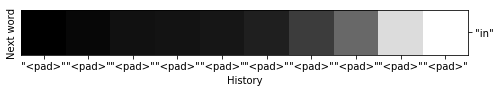

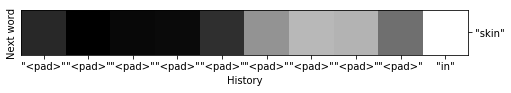

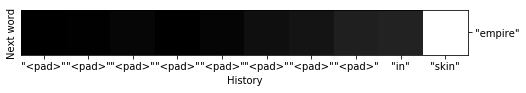

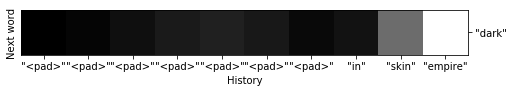

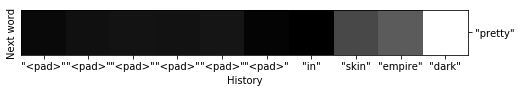

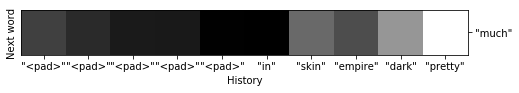

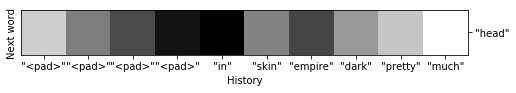

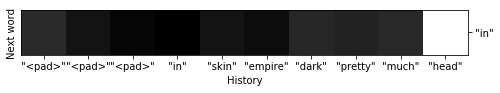

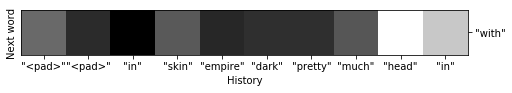

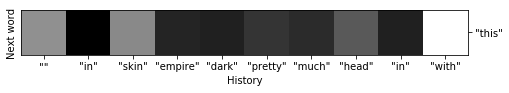

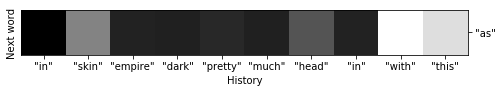

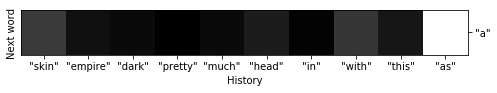

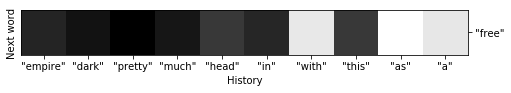

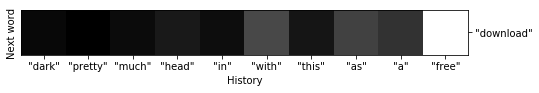

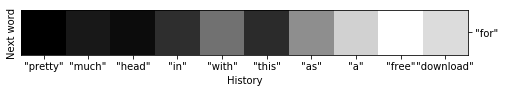

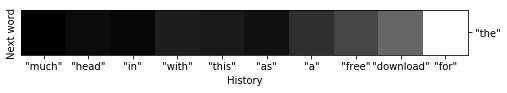

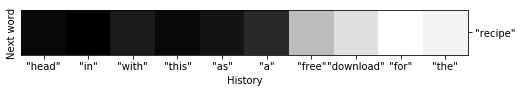

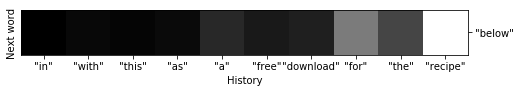

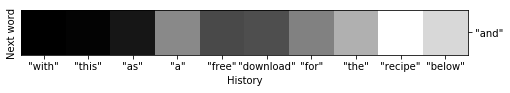

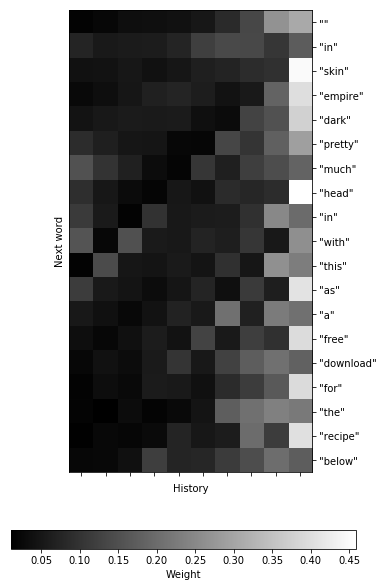

In [11]:
sample(textgen, temperature=1.0)